In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pipe import select, where, sort
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import presentation as p 

# Preparing Data

In [2]:
training_df = pd.read_csv('data/network-traffic/kddcup.data.corrected.csv', index_col=False).drop_duplicates()
testing_df = pd.read_csv('data/network-traffic/corrected.csv', index_col=False).drop_duplicates()
complete_df = pd.read_csv('data/network-traffic/kddcup.data.complete.csv', index_col=False).drop_duplicates()

complete_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,attack_class
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal,normal


In [3]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074992 entries, 0 to 1074991
Data columns (total 43 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   duration                     1074992 non-null  int64  
 1   protocol_type                1074992 non-null  object 
 2   service                      1074992 non-null  object 
 3   flag                         1074992 non-null  object 
 4   src_bytes                    1074992 non-null  int64  
 5   dst_bytes                    1074992 non-null  int64  
 6   land                         1074992 non-null  int64  
 7   wrong_fragment               1074992 non-null  int64  
 8   urgent                       1074992 non-null  int64  
 9   hot                          1074992 non-null  int64  
 10  num_failed_logins            1074992 non-null  int64  
 11  logged_in                    1074992 non-null  int64  
 12  num_compromised              1074992 non-n

In [4]:
# Create column to verify if it is an attack or not
training_df['is_attack'] = training_df.target.map(lambda a_type: a_type != 'normal')
testing_df['is_attack'] = testing_df.target.map(lambda a_type: a_type != 'normal')
complete_df['is_attack'] = complete_df.target.map(lambda a_type: a_type != 'normal')

In [5]:
# Label encode the target and categorical variables
categorical_columns = ['protocol_type', 'service', 'flag', 'target', 'attack_class', 'is_attack']

label_encoder = LabelEncoder()

for col in categorical_columns:
    training_df[col] = label_encoder.fit_transform(training_df[col])
    testing_df[col] = label_encoder.fit_transform(testing_df[col])
    complete_df[col] = label_encoder.fit_transform(complete_df[col])

In [6]:
training_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target', 'attack_class', 'is_attack'],
      dtype='object')

# Metrics and reduced Dataset

In [7]:
# Metrics
beta = 10
fbeta_scorer = make_scorer(fbeta_score, beta=beta)

# Finding the best model
BEST_MODEL_IS_ATTACK = None
BEST_SCORE_IS_ATTACK = None
BEST_MODEL_ATTACK_GROUP = None
BEST_SCORE_ATTACK_GROUP = None

In [8]:
# Important Data Subset (15 Most Important Features)
feature_imp_attack = {
   'same_srv_rate': 0.21199866684770505, 'count': 0.1385794555921013, 'diff_srv_rate': 0.11660354574720663, 
   'src_bytes': 0.07133604504271888, 'flag': 0.0689813541719748, 'dst_host_srv_serror_rate': 0.0621598020912925, 
   'dst_bytes': 0.057168688956664895, 'dst_host_same_srv_rate': 0.05254858459557669, 'srv_serror_rate': 0.04469331875735019, 
   'serror_rate': 0.04097324469080398, 'service': 0.01868051080047695, 'dst_host_serror_rate': 0.01802081827734208, 
   'dst_host_srv_count': 0.011545183650792126, 'dst_host_same_src_port_rate': 0.011337335403034117, 'protocol_type': 0.01111283067949643, 
   'srv_count': 0.009167672319969513, 'dst_host_count': 0.00873490361773566, 'dst_host_srv_rerror_rate': 0.008354143406230159, 
   'dst_host_diff_srv_rate': 0.007982036329319523, 'logged_in': 0.007096409133012435, 'dst_host_srv_diff_host_rate': 0.006912055417103559, 
   'dst_host_rerror_rate': 0.0048513483664072345, 'rerror_rate': 0.0025784179881967813, 'wrong_fragment': 0.0020432908004560796, 
   'srv_rerror_rate': 0.0016133665984154693, 'num_compromised': 0.001456082442758954, 'duration': 0.0013066127485688805, 
   'hot': 0.0012589559107352938, 'srv_diff_host_rate': 0.0006086465735149157, 'is_guest_login': 0.00013464784144864953, 
   'num_root': 4.6925733316063196e-05, 'num_failed_logins': 4.487859382061017e-05, 'num_file_creations': 2.0557845839487765e-05, 
   'root_shell': 1.7416012225572053e-05, 'num_access_files': 1.2171215578937403e-05, 'num_shells': 8.344719212122783e-06, 
   'urgent': 4.825536792287678e-06, 'land': 4.449872331211087e-06, 'su_attempted': 2.354686052141186e-06, 
   'is_host_login': 1.0098642182210754e-07, 'num_outbound_cmds': 0.0
}

feature_imp_attack_class = {
   'count': 0.17385536847050378, 'dst_host_diff_srv_rate': 0.16534192463609285, 'diff_srv_rate': 0.10254320729049028, 
   'dst_host_same_src_port_rate': 0.08935524484241128, 'src_bytes': 0.06294894120539953, 'same_srv_rate': 0.06266221897844468, 
   'srv_count': 0.033477361412496846, 'dst_host_srv_diff_host_rate': 0.02985837864005727, 'dst_host_serror_rate': 0.02397819057338417, 
   'dst_host_rerror_rate': 0.02270848553479628, 'flag': 0.02261474009181149, 'dst_host_count': 0.02122279595653549, 
   'dst_host_srv_count': 0.02018236362613821, 'rerror_rate': 0.019581932778250603, 'service': 0.01929291941472073, 
   'protocol_type': 0.017131606487459122, 'dst_host_same_srv_rate': 0.016847303696007312, 'srv_diff_host_rate': 0.015281253769726545, 
   'serror_rate': 0.01428655250033731, 'logged_in': 0.010248503497316944, 'dst_host_srv_serror_rate': 0.009237924881051724, 
   'wrong_fragment': 0.007985681738000482, 'duration': 0.007656807637643944, 'srv_serror_rate': 0.006918207069047998, 
   'dst_bytes': 0.006286666021650419, 'dst_host_srv_rerror_rate': 0.005842311030619984, 'hot': 0.005058255448651374, 
   'is_guest_login': 0.002493649080574099, 'srv_rerror_rate': 0.0022021571945202234, 'num_compromised': 0.001800962024192526, 
   'num_failed_logins': 0.0004716818681954542, 'root_shell': 0.00018912178300909527, 'num_file_creations': 0.00017914153458179928, 
   'num_root': 9.446178745950394e-05, 'land': 8.349735882600549e-05, 'num_access_files': 3.9353623828989734e-05, 
   'num_shells': 2.1600402461996604e-05, 'urgent': 1.5411543725298135e-05, 'su_attempted': 3.8145695782391786e-06, 
   'num_outbound_cmds': 0.0, 'is_host_login': 0.0
}

def feature(ranking): return ranking[0]
def importance(ranking): return ranking[1]
def top_n_features(n, features):
    return list(
        list(features.items())
        | sort(importance, reverse=True)
        | select(feature)
    )[:n]
def features_above(threshold, features):
    return list(
        list(features.items())
        | where(lambda feature: importance(feature) >= threshold)
        | select(feature)
    )


In [9]:
# For SVM, we will restrict ourselves to the top 15 respective most important features.
top_features_attack = top_n_features(15, feature_imp_attack)
top_features_attack_class = top_n_features(15, feature_imp_attack_class)

In [10]:
# Attack Detection
X_train_attack = training_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_attack = training_df['is_attack']

X_test_attack = testing_df.drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_attack = testing_df['is_attack']

# Attack Classification
X_train_class = training_df[training_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_train_class = training_df[training_df['attack_class'] != 1]['attack_class']

X_test_class = testing_df[testing_df['attack_class'] != 1].drop(['target', 'attack_class', 'is_attack'], axis=1)
y_test_class = testing_df[testing_df['attack_class'] != 1]['attack_class']

In [11]:
# Top 15 Important Features For Attack Detection
X_train_attack_reduced = training_df[top_features_attack]
y_train_attack_reduced = training_df['is_attack']

X_test_attack_reduced = testing_df[top_features_attack]
y_test_attack_reduced = testing_df['is_attack']

# Top 15 Important Features For Attack Classification
X_train_class_reduced = training_df[training_df['attack_class'] != 1][top_features_attack_class]
y_train_class_reduced = training_df[training_df['attack_class'] != 1]['attack_class']

X_test_class_reduced = testing_df[testing_df['attack_class'] != 1][top_features_attack_class]
y_test_class_reduced = testing_df[testing_df['attack_class'] != 1]['attack_class']

In [12]:
scaler = StandardScaler()
X_train_attack_scaled = scaler.fit_transform(X_train_attack)
X_test_attack_scaled = scaler.transform(X_test_attack)

X_train_class_scaled = scaler.fit_transform(X_train_class)
X_test_class_scaled = scaler.transform(X_test_class)


# KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# Train the KNN Attack Detection Model
knn_model_attack = KNeighborsClassifier(n_neighbors=100)
knn_model_attack.fit(X_train_attack, y_train_attack)

# Train the KNN Attack Classification Model
knn_model_class = KNeighborsClassifier(n_neighbors=100)
knn_model_class.fit(X_train_class, y_train_class)

KNeighborsClassifier(n_neighbors=100)

In [15]:
# Attack Detection Predictions
knn_attack_pred = knn_model_attack.predict(X_test_attack)

# Attack Classification Predictions
knn_class_pred = knn_model_attack.predict(X_test_class)

In [16]:
# Evaluate the KNN Attack Detection Model
accuracy = accuracy_score(y_test_attack, knn_attack_pred)
fbeta = fbeta_score(y_test_attack, knn_attack_pred, beta=beta)
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_attack, knn_attack_pred))


Accuracy: 0.9267443816226987, F-beta Score: 0.8190136537160497
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     47913
           1       0.99      0.82      0.89     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291



In [17]:
# Evaluate the KNN Attack Classification Model
accuracy = accuracy_score(y_test_class, knn_class_pred)
fbeta = fbeta_score(y_test_class, knn_class_pred, beta=beta, average='weighted')
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_class, knn_class_pred, zero_division=1))

Accuracy: 0.06978010756348288, F-beta Score: 0.07031924837349039
              precision    recall  f1-score   support

           0       0.38      0.09      0.14     23747
           1       0.00      1.00      0.00         0
           2       1.00      0.00      0.00      3041
           3       1.00      0.00      0.00      2533
           4       1.00      0.00      0.00        57

    accuracy                           0.07     29378
   macro avg       0.68      0.22      0.03     29378
weighted avg       0.50      0.07      0.11     29378



Confusion Matrix Attack Detection KNN


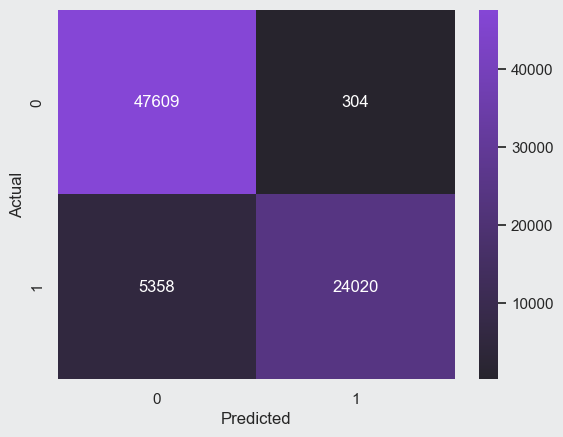

In [18]:
# Print Confusion Matrix 
print('Confusion Matrix Attack Detection KNN')
conf_matrix_attack = confusion_matrix(y_test_attack, knn_attack_pred)
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Confusion Matrix Attack Classification KNN


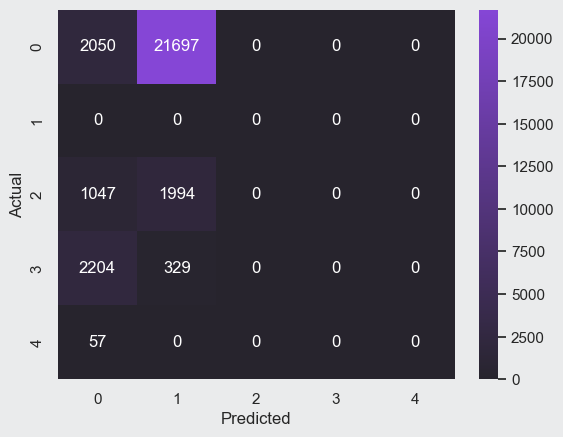

In [19]:
# Print Confusion Matrix 
print('Confusion Matrix Attack Classification KNN')
conf_matrix_class = confusion_matrix(y_test_class, knn_class_pred)
sns.heatmap(conf_matrix_class, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [21]:
# Train the Naive Bayes Attack Detection Model
nb_model_attack = GaussianNB()
nb_model_attack.fit(X_train_attack, y_train_attack)

# Train the Naive Bayes Attack Classification Model
nb_model_class = GaussianNB()
nb_model_class.fit(X_train_class, y_train_class)

GaussianNB()

In [22]:
# Attack Detection Predictions Naive Bayes
nb_attack_pred = nb_model_attack.predict(X_test_attack)

# Attack Classification Predictions Naive Bayes
nb_class_pred = nb_model_class.predict(X_test_class)

In [23]:
# Evaluate the Naive Bayes Attack Detection Model
accuracy = accuracy_score(y_test_attack, nb_attack_pred)
fbeta = fbeta_score(y_test_attack, nb_attack_pred, beta=beta)
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_attack, nb_attack_pred))

Accuracy: 0.6747098627265787, F-beta Score: 0.16246306530136267
              precision    recall  f1-score   support

           0       0.66      0.99      0.79     47913
           1       0.90      0.16      0.27     29378

    accuracy                           0.67     77291
   macro avg       0.78      0.58      0.53     77291
weighted avg       0.75      0.67      0.59     77291



In [24]:
# Evaluate the Naive Bayes Attack Classification Model
accuracy = accuracy_score(y_test_class, nb_class_pred)
fbeta = fbeta_score(y_test_class, nb_class_pred, beta=beta, average='weighted')
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_class, nb_class_pred))

Accuracy: 0.77023623119341, F-beta Score: 0.7690404790056776
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     23747
           2       0.00      0.00      0.00      3041
           3       0.18      0.10      0.13      2533
           4       0.48      0.40      0.44        57

    accuracy                           0.77     29378
   macro avg       0.37      0.36      0.36     29378
weighted avg       0.67      0.77      0.72     29378



Confusion Matrix Attack Detection Naive Bayes


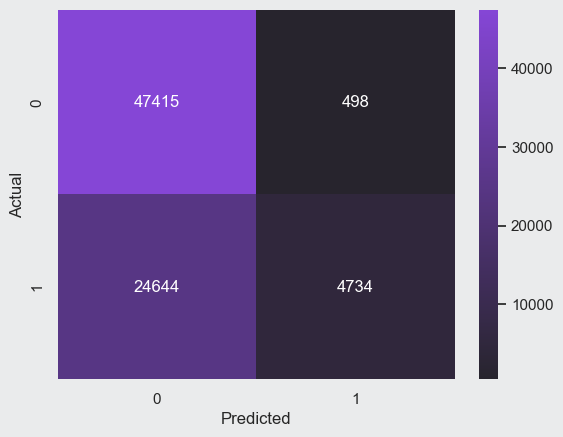

In [25]:
# Print Confusion Matrix
print('Confusion Matrix Attack Detection Naive Bayes')
conf_matrix_attack = confusion_matrix(y_test_attack, nb_attack_pred)
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Confusion Matrix Attack Classification Naive Bayes


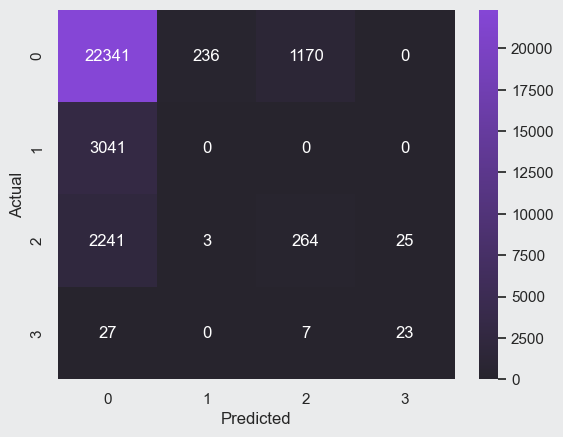

In [26]:
# Print Confusion Matrix
print('Confusion Matrix Attack Classification Naive Bayes')
conf_matrix_class = confusion_matrix(y_test_class, nb_class_pred)
sns.heatmap(conf_matrix_class, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

- First run with max_iter = 10000 (reached limit at 10 minutes / interrupted). 
- Second run with max_iter = 50000 (evaluations exceeds limit in 24 minutes / interrupted).
- Third run with reduced dataset and max_iter = 10000 (reached limit in 13 minutes / stopped).
- Fourth run with reduced dataset and max_iter = 50000 (evaluations exceeds limit in 19 minutes / stopped).
- Fifth run with scaled dataset and max_iter=10000 (11 seconds / successful).
- Maybe one more try with scaling before encoding..

In [28]:
#Train the LR Attack Detection Model
lr_model_attack = LogisticRegression(max_iter= 10000)
lr_model_attack.fit(X_train_attack_scaled, y_train_attack)

#Train the LR Attack Classification Model
lr_model_class = LogisticRegression(max_iter= 10000)
lr_model_class.fit(X_train_class_scaled, y_train_class)

LogisticRegression(max_iter=10000)

In [29]:
# LR Attack Detection Model Predictions
lr_attack_pred = lr_model_attack.predict(X_test_attack_scaled)

# LR Attack Classification Model Predictions
lr_class_pred = lr_model_class.predict(X_test_class_scaled)

In [30]:
# Evaluate the Attack Detection Model
accuracy = accuracy_score(y_test_attack, lr_attack_pred)
fbeta = fbeta_score(y_test_attack, lr_attack_pred, beta=beta)
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_attack, lr_attack_pred))

Accuracy: 0.9146989947083102, F-beta Score: 0.7982587134386038
              precision    recall  f1-score   support

           0       0.89      0.99      0.93     47913
           1       0.97      0.80      0.88     29378

    accuracy                           0.91     77291
   macro avg       0.93      0.89      0.91     77291
weighted avg       0.92      0.91      0.91     77291



In [31]:
# Evaluate the Attack Classification Model
accuracy = accuracy_score(y_test_class, lr_class_pred)
fbeta = fbeta_score(y_test_class, lr_class_pred, beta=beta, average='weighted')
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_class, lr_class_pred))

Accuracy: 0.9076179454013207, F-beta Score: 0.9071648473360115
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     23747
           2       0.63      0.89      0.74      3041
           3       0.90      0.22      0.35      2533
           4       0.25      0.35      0.29        57

    accuracy                           0.91     29378
   macro avg       0.69      0.61      0.59     29378
weighted avg       0.92      0.91      0.89     29378



Confusion Matrix Attack Detection Logistic Regression


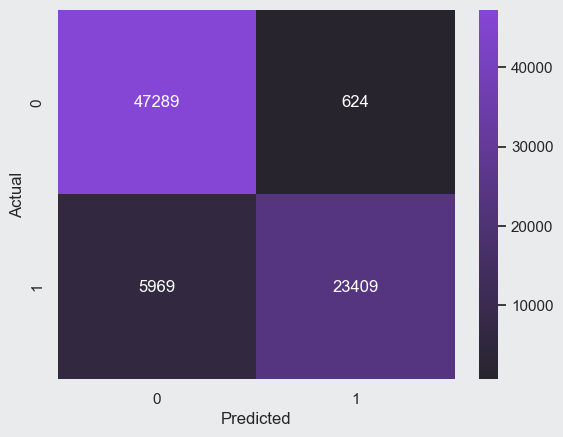

In [32]:
# Print Confusion Matrix
print('Confusion Matrix Attack Detection Logistic Regression')
conf_matrix_attack = confusion_matrix(y_test_attack, lr_attack_pred)
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Confusion Matrix Attack Classification Logistic Regression


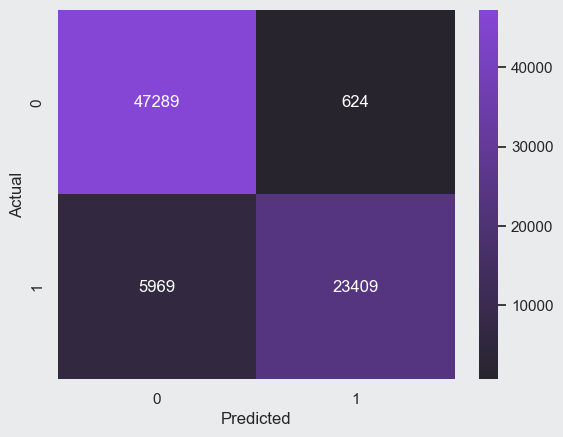

In [33]:
# Print Confusion Matrix
print('Confusion Matrix Attack Classification Logistic Regression')
conf_matrix_class = confusion_matrix(y_test_class, lr_class_pred)
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Support Vector Machine

In [34]:
from sklearn.svm import SVC

- First run with reduced dataset and max_iter = 10000 (reached limit at 32 seconds / stopped). 
- Second run with reduced dataset and max_iter = 50000 (reached limit at 2 minutes / stopped).
- Third run with reduced dataset and without max_iter (30 minutes / interrupted).
- Fourth run with scaled dataset and with verbose=True, kernel='linear', C=1. (30 minutes / interrupted).
- Fifth run with scaled dataset and with kernel='linear', C=1. (20 minutes / interrupted).
- Sixth run with scaled dataset and with only max_iter = 50000 (4 minutes / successful).
- Maybe one more try with scaling before encoding and with max_iter parameter..

In [35]:
# For this Model we will start with the reduced Dataset

#Train the SVM Attack Detection Model
svm_model_attack = SVC(max_iter = 50000)
svm_model_attack.fit(X_train_attack_scaled, y_train_attack)

#Train the SVM Attack Classification Model
svm_model_class = SVC(max_iter = 50000)
svm_model_class.fit(X_train_class_scaled, y_train_class)

SVC(max_iter=50000)

In [36]:
# SVM Attack Detection Model Predictions
svm_attack_pred = svm_model_attack.predict(X_test_attack_scaled)

# SVM Attack Classification Model Predictions
svm_class_pred = svm_model_class.predict(X_test_class_scaled)

In [37]:
# Evaluate the Attack Detection Model
accuracy = accuracy_score(y_test_attack, svm_attack_pred)
fbeta = fbeta_score(y_test_attack, svm_attack_pred, beta=beta)
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_attack, svm_attack_pred))

Accuracy: 0.9285686561177886, F-beta Score: 0.8202938025838126
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     47913
           1       0.99      0.82      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.95      0.91      0.92     77291
weighted avg       0.93      0.93      0.93     77291



Confusion Matrix Attack Detection SVM


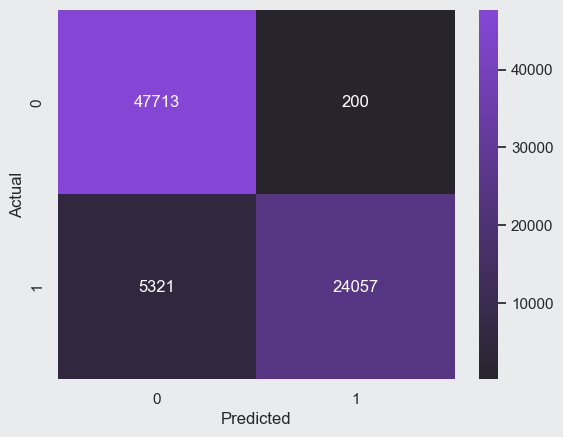

In [38]:
# Print Confusion Matrix
print('Confusion Matrix Attack Detection SVM')
conf_matrix_attack = confusion_matrix(y_test_attack, svm_attack_pred)
sns.heatmap(conf_matrix_attack, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
# Evaluate the Attack Classification Model
accuracy = accuracy_score(y_test_class, svm_class_pred)
fbeta = fbeta_score(y_test_class, svm_class_pred, beta=beta, average='weighted')
print(f'Accuracy: {accuracy}, F-beta Score: {fbeta}')
print(classification_report(y_test_class, svm_class_pred))

Accuracy: 0.8873646946694805, F-beta Score: 0.8870765016096429
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     23747
           2       0.55      0.91      0.69      3041
           3       0.98      0.34      0.50      2533
           4       0.06      0.14      0.08        57

    accuracy                           0.89     29378
   macro avg       0.64      0.58      0.56     29378
weighted avg       0.92      0.89      0.88     29378



Confusion Matrix Attack Detection SVM


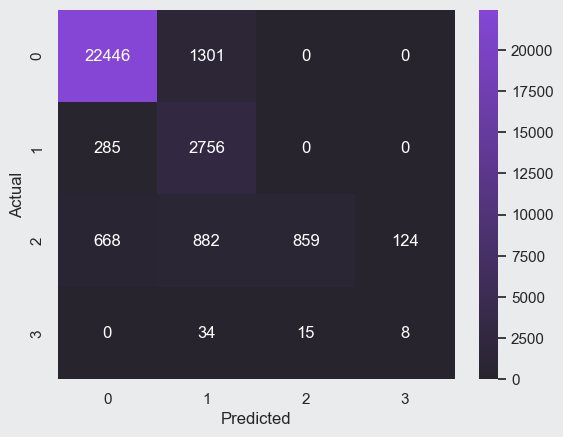

In [42]:
# Print Confusion Matrix
print('Confusion Matrix Attack Detection SVM')
conf_matrix_class = confusion_matrix(y_test_class, svm_class_pred)
sns.heatmap(conf_matrix_class, annot=True, fmt='d', cmap=p.Colors.purples_c)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()